## Notes
    Complete: Provide user with top k previously wines, based on productKey


#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cPickle
from time import time
from sklearn.utils import shuffle
import pyspark
% matplotlib inline

In [2]:
from pyspark.mllib.recommendation import ALS
import math

#### Import Data

In [3]:
home = "/Users/Alexander/WINE/data/"
pseudo_ratings_path = home + "ratings_df.pkl"
wine_path = home + "wine_df_red_white_only.pkl"

In [4]:
products_df = pd.read_pickle(wine_path)

In [5]:
products_df.head()

,ProductKey,ProductId,Appellation,Varietal,Vineyard
0,2,127554,Napa Valley,Cabernet Sauvignon,Turnbull
1,3,133070,Napa Valley,Cabernet Sauvignon,Turnbull
2,4,114037,Napa Valley,Cabernet Sauvignon,Turnbull
5,7,109508,Napa Valley,Other Red Blends,Turnbull
6,8,110277,Napa Valley,Merlot,Turnbull


In [6]:
rating_df = pd.read_pickle(pseudo_ratings_path)

In [7]:
rating_df.head()

,CustomerHash,ProductKey,Ratings
0,D3BE5BC2AA8796FCD402023CD6E5A6AC,95350,5
1,64F6A2CEC420680A259172BF4CF17CE2,95375,4
2,6131DC57D6050C3EB674DD8722C83B2B,79964,5
3,525CD8F0BF94E814F16F4FA947B995B6,102020,5
4,710DBFAAB43DF7B5E304ED0D26B7966A,129946,3


#### Get Subset of Data

In [8]:
# Spark keeps crashing when using full data set
# Perhaps running Sparking on AWS cluster will help
rating_df = rating_df.sample(n = 500000)

### Format Data for Spark Recommender
    Data needs to be in this form --> (user_id, item_id, n_purchases)

In [9]:
# number of nodes in local spark cluster
n_nodes = 3
sc = pyspark.SparkContext(master = "local[{}]".format(n_nodes))

In [10]:
def get_df_values_by_col(df):
    cust_tags = df.CustomerHash.values
    wine_productKeys = df.ProductKey.values
    ratings = df.Ratings.values
    return cust_tags, wine_productKeys, ratings

In [11]:
def create_userHash_userid_pairs(cust_tags):
    # create int:cust_tag key value pairs
    # spark can't read string user ids
    index_to_int = np.arange(0, len(cust_tags) * 100, 100)
    return  index_to_int, [ [tag_int, tag_hash] for tag_hash, tag_int in zip(cust_tags, index_to_int)]

In [12]:
cust_tags, wine_productKeys, ratings = get_df_values_by_col(rating_df)

In [13]:
index_to_int, cust_tag_bridge = create_userHash_userid_pairs(cust_tags)

#### Wine Products RDD

In [14]:
# create products_rdd
products_rdd = sc.parallelize(products_df.values.tolist())

In [15]:
# format --> (productKey, (productID, Appellation, Varietal, Vinyard) )
products_rdd = products_rdd.map(lambda row: (row[0], (row[1], row[2], row[3], row[4]) )   )

In [16]:
products_rdd.take(2)

[(2, (127554, 'Napa Valley', 'Cabernet Sauvignon', 'Turnbull')),
 (3, (133070, 'Napa Valley', 'Cabernet Sauvignon', 'Turnbull'))]

In [17]:
complete_data = rating_df.values.tolist()

In [18]:
# create bride rdd for customer tags and customer ids
cust_tag_bridge_rdd = sc.parallelize(cust_tag_bridge)

### Move Complete Data to RDD

In [19]:
complete_data_rdd = sc.parallelize(complete_data)

In [20]:
complete_data_rdd = complete_data_rdd.map(lambda row: (row[0], (row[1], row[2])) )

In [21]:
cust_tag_bridge_rdd = cust_tag_bridge_rdd.map(lambda row: (row[1],row[0]))

In [22]:
complete_data_id_bridge_rdd = \
complete_data_rdd.join(cust_tag_bridge_rdd)

In [23]:
# format -->  (user_id, wine_id, rating)
clean_data_rdd =\
complete_data_id_bridge_rdd.map(lambda row: (row[1][1], row[1][0][0], row[1][0][1] )   )

In [24]:
# save spark ready data to file
# path = "/Users/Alexander/WINE/data/spark_ready_data.pkl"
# cPickle.dump(clean_data_local, open(path, "w"))

In [25]:
#load spark ready data 
# path = "/Users/Alexander/WINE/data/spark_ready_data.pkl"
# data = cPickle.load(open(path , 'r'))

### Create Train, Test, and Validation Sets

In [26]:
# split data into sets in appropriate proprotions, i.e. weights = [6, 2, 2]
training_RDD, validation_RDD, test_RDD = clean_data_rdd.randomSplit([6, 2, 2], seed=0)

In [27]:
# format data so that the key is (user_id, wine_feat)
validation_for_predict_RDD = validation_RDD.map(lambda x: (x[0], x[1]))
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

In [28]:
# sanity check
training_RDD.take(5)

[(1162600, 8630, 4),
 (5744500, 91637, 5),
 (18133500, 91637, 5),
 (27481500, 91637, 5),
 (32731000, 91637, 5)]

In [29]:
validation_for_predict_RDD.take(5)

[(15536500, 91637),
 (17967100, 91637),
 (29664800, 91637),
 (31077900, 91637),
 (5744500, 85829)]

In [30]:
test_for_predict_RDD.take(5)

[(32905700, 58268),
 (20118200, 91637),
 (20867000, 91637),
 (22829500, 91637),
 (24221400, 91637)]

### Train Recommender

In [31]:
seed = 5L
iterations = 10
regularization_parameter = 0.1
ranks = [8, 12, 16]
errors = [0, 0, 0]
err = 0
tolerance = 0.02

In [32]:
min_error = float('inf')
best_rank = -1
best_iteration = -1

In [33]:
# pre-liminary run shows that ALS.train performs much better than ALS.trainImplict

# iterate through ranks (n_latent feats) to find best performing model
for rank in ranks:
    model = ALS.train(training_RDD, 
                      rank, 
                      seed=seed, 
                      iterations=iterations,
                      lambda_=regularization_parameter,
                      nonnegative=True)
    
#     model = ALS.trainImplicit(ratings=training_RDD, 
#                       rank=rank, 
#                       seed=seed, 
#                       iterations=iterations,
#                       lambda_=regularization_parameter,
#                       alpha=0.1,
#                       nonnegative=True)

    # (r[0], r[1]), r[2]) --> user_id, wine_id, rating 
    predictions = model.predictAll(validation_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
    
    # combine predictions and validation sets
    rates_and_preds = validation_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2])))\
                                    .join(predictions)
    # get RMSE for each rank
    error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
    # store rank's error to list
    errors[err] = error
    err += 1
    
    print 'For rank %s the RMSE is %s' % (rank, error)
    # assign best performing rank
    if error < min_error:
        min_error = error
        best_rank = rank

print 'The best model was trained with rank %s' % best_rank

For rank 12 the RMSE is 0.282031090896
The best model was trained with rank 12


In [34]:
predictions.take(3)

[((16530300, 43104), 4.855068138767528),
 ((16530300, 84993), 4.829131104728967),
 ((16530300, 84993), 4.829131104728967)]

In [35]:
validation_RDD.take(1)

[(15536500, 91637, 5)]

In [36]:
# ( (user_id, wine_id), (true_rating, pred_rating)  )
rates_and_preds.take(5)

[((12248400, 95473), (5.0, 4.606306783490254)),
 ((20425300, 4109), (5.0, 4.804794030363759)),
 ((49201400, 53032), (4.0, 3.8254028142251393)),
 ((28699100, 56507), (5.0, 4.807317246380448)),
 ((14475400, 38369), (4.0, 3.852179366988439))]

### Test Best Performing Model with Test Set

In [37]:
model_best = ALS.train(training_RDD, 
                  best_rank, 
                  seed=seed, 
                  iterations=iterations,
                  lambda_=regularization_parameter)

predictions = model_best.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))

rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)

error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
print 'For testing data the RMSE is %s' % (error)

For testing data the RMSE is 0.382633786773


In [38]:
predictions.take(1)

[((31534200, 6306), 4.725018152874531)]

###  Assign user tags and wine names to predictions

In [39]:
products_rdd.take(2)

[(2, (127554, 'Napa Valley', 'Cabernet Sauvignon', 'Turnbull')),
 (3, (133070, 'Napa Valley', 'Cabernet Sauvignon', 'Turnbull'))]

In [40]:
cust_tag_bridge_rdd.take(2)

[('7FB94B0031E91D1A154EF2ABE5A592B9', 0),
 ('23BF359699C02CBFAA556A0F83E37F6F', 100)]

In [41]:
predictions.map(lambda row: (row[0][0], (row[0][1], row[1]) ) ).take(5)

[(31534200, (6306, 4.725018152874531)),
 (16530300, (21067, 4.847240108239152)),
 (16530300, (25253, 4.8431486448950025)),
 (28975200, (140103, 3.823485597797087)),
 (28975200, (140460, 1.9168850711443555))]

In [42]:
# format --> (wine_id, (user_tag, rating)  )
wineID_userTag_ratings_rdd = \
predictions.map(lambda row: (row[0][0], (row[0][1], row[1]) ) )\
           .join(cust_tag_bridge_rdd)\
           .map(lambda row: (row[1][0][0],  (row[1][1], row[1][0][1])  ) )

In [43]:
# format --> (wine_id, appellation, varietal, vineyard, user_tag, rating)
complete_prediction_data =\
wineID_userTag_ratings_rdd.join(products_rdd)\
                          .map(lambda row: (row[1][1][0], 
                                            row[1][1][1], 
                                            row[1][1][2], 
                                            row[1][1][3], 
                                            row[1][0][0], 
                                            row[1][0][1]  ) ) 

### Get top K recommendations for an existing user

In [44]:
# will get K predictions for user with this id
user_id = 0

In [45]:
#Let's now get some recommendations! 
#For that we will get an RDD with all the movies the new user hasn't rated yet. 
#We will them together with the model to predict ratings.
clean_data_rdd.take(2)

[(32905700, 58268, 5), (1162600, 8630, 4)]

In [46]:
# ( user_id, movie_id, rating  )
# get user 0's movie ids in a list
movie_ids = clean_data_rdd.filter(lambda row: row[0] == user_id )\
                           .map(lambda row: row[1]).collect()

In [47]:
# wine_ids that user_id has not purchased
movie_ids

[140922]

In [48]:
# get wine_ids that user 0 has not purchased 
unpurchased_wines = \
clean_data_rdd.filter(lambda row: row[0] != user_id )\
    .filter(lambda row: row[2] not in  movie_ids)\
    .map(lambda row: (user_id, row[1] ) ).distinct()

In [49]:
unpurchased_wines.count()

39899

#### Get Recommendations for Single User

In [50]:
user_recs = model_best.predictAll(unpurchased_wines)

In [51]:
# Wine Recommendations, for user 0, without prior purchase 
user_recs.take(5)

[Rating(user=0, product=18624, rating=0.46908649515432366),
 Rating(user=0, product=120018, rating=1.8333220174762752),
 Rating(user=0, product=23556, rating=0.9080505226436114),
 Rating(user=0, product=76569, rating=2.477164601205952),
 Rating(user=0, product=84750, rating=3.096918076105213)]

### Distribution of Predicted Ratings for User

In [52]:
local_ratings = user_recs.map(lambda row: row[2]).collect()

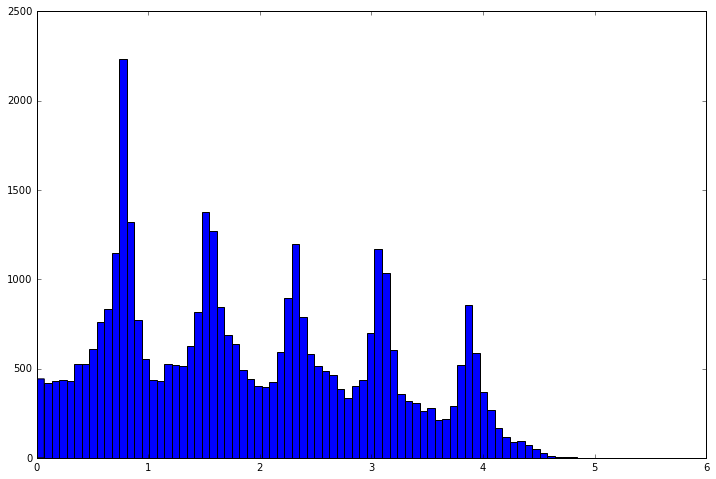

In [69]:
plt.figure(figsize = (12, 8));
plt.hist(np.abs(local_ratings), bins = 80);

#### Get Count of Ratings for Each Wine

In [55]:
# build wine_purchase_count rdd to filter out unpopular recommendations 
# get ( wine_id, n_total_purchases )
wine_id_with_purchases_rdd = \
clean_data_rdd.map(lambda row: (row[1], row[2]) ).groupByKey()

In [56]:
def get_counts_and_averages(ID_and_purchases_tuple):
    n_purchases = float(sum(x for x in ID_and_purchases_tuple[1]))
    ave_norm = len(ID_and_purchases_tuple[1])
    # ( wine_id,  ( n_purchases, ave_n_purchases )    )
    return ID_and_purchases_tuple[0], (n_purchases, n_purchases /ave_norm)

In [57]:
wine_id_with_purchase_count_and_ave_rdd = wine_id_with_purchases_rdd.map(get_counts_and_averages)

In [58]:
wine_id_with_purchase_count_rdd = \
wine_id_with_purchase_count_and_ave_rdd.map(lambda row: (row[0], row[1][0]) )

In [59]:
# format -->  (wine_id, ratings_count )
wine_id_with_purchase_count_rdd.take(1)

[(6, 9.0)]

In [60]:
user_recs.map(lambda row: (row[1], row[2] ))\
         .join(wine_id_with_purchase_count_rdd)\
         .join(products_rdd)\
         .take(1)

[(48,
  ((1.1913236228633604, 56.0),
   (122791, 'Sonoma County', 'Pinot Noir', 'Patz & Hall')))]

In [61]:
# format --> (productID, Appellation, Varietal, Vineyard, Rating, Rating Count)
user_recs_clean = \
user_recs.map(lambda row: (row[1], row[2] ))\
         .join(wine_id_with_purchase_count_rdd)\
         .join(products_rdd)\
         .map(lambda row: (row[1][1][0], 
                           row[1][1][1], 
                           row[1][1][2], 
                           row[1][1][3], 
                           row[1][0][0], 
                           row[1][0][1] ))

In [62]:
user_recs_clean.take(1)

[(122791,
  'Sonoma County',
  'Pinot Noir',
  'Patz & Hall',
  1.1913236228633604,
  56.0)]

### Top k Recommendations for Single User, m 

In [63]:
# ( wine_tag, pred_rating, total_n_purchases  )
# the neg in "key" indicates descending order
top_k = 10
top_k_wine_recs = user_recs_clean.takeOrdered(top_k, key=lambda row: -row[4])

In [64]:
top_k_wine_recs

[(84369,
  'Other Australia',
  'Chardonnay',
  'Trevor Jones',
  5.380739349420712,
  415.0),
 (126839,
  'Other California',
  'Other White Blends',
  'Fifty Shades of Grey',
  5.066814392958143,
  355.0),
 (138923, 'Napa Valley', 'Chardonnay', 'Cakebread', 4.984116896715815, 150.0),
 (85667,
  'Central Coast',
  'Chardonnay',
  'Kendall-Jackson',
  4.9229526202898235,
  705.0),
 (91207,
  'Central Coast',
  'Chardonnay',
  'Bernardus',
  4.873421558144883,
  1340.0),
 (126267,
  'Marlborough',
  'Sauvignon Blanc',
  'Brancott',
  4.807674054085124,
  740.0),
 (105082,
  'Sonoma County',
  'Pinot Noir',
  'Hartford Court',
  4.740581647742314,
  1140.0),
 (110001,
  'Napa Valley',
  'Cabernet Sauvignon',
  'Hall',
  4.7305402482237175,
  1195.0),
 (88591,
  'Chateauneuf-du-Pape',
  'Rhone Red Blends',
  'Guigal',
  4.726060758550213,
  180.0),
 (131570,
  'Central Coast',
  'Sauvignon Blanc',
  'SeaGlass',
  4.691501604480356,
  800.0)]